# Projet Deep Learning
by Thomas ODIN, Maïa JOUENNE et Benoit CATEZ

## Import et telechargement des paquets necessaires

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

## 1) Classification

### Crop et annotation

Number of valid cropped images: 2075
Number of proposed images: 2077
Image sizes:
(106, 169, 3)    6
(70, 64, 3)      6
(43, 72, 3)      4
(2, 1, 3)        4
(131, 262, 3)    4
                ..
(93, 56, 3)      1
(87, 41, 3)      1
(72, 70, 3)      1
(51, 61, 3)      1
(53, 84, 3)      1
Name: cropped_image, Length: 1023, dtype: int64


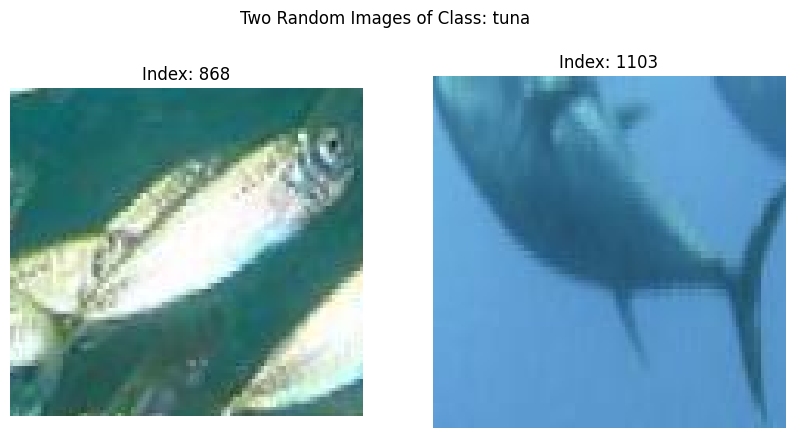

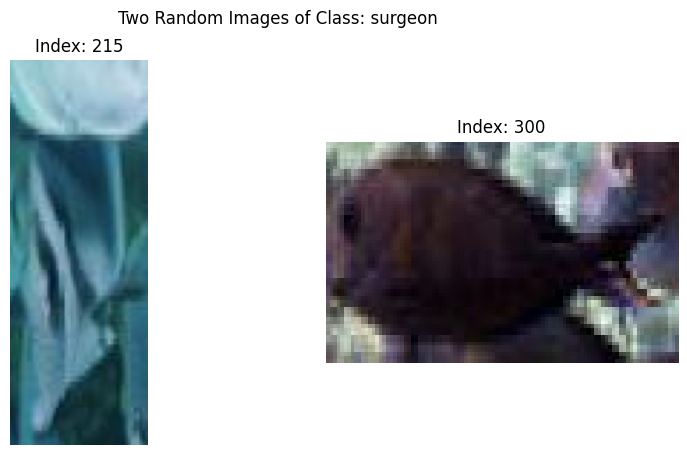

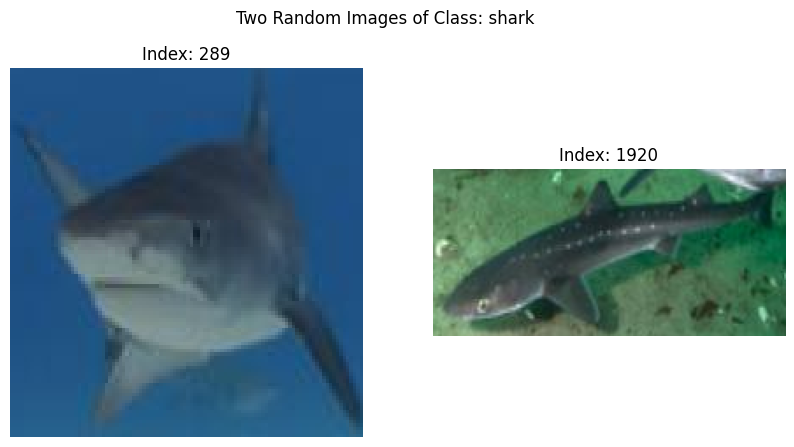

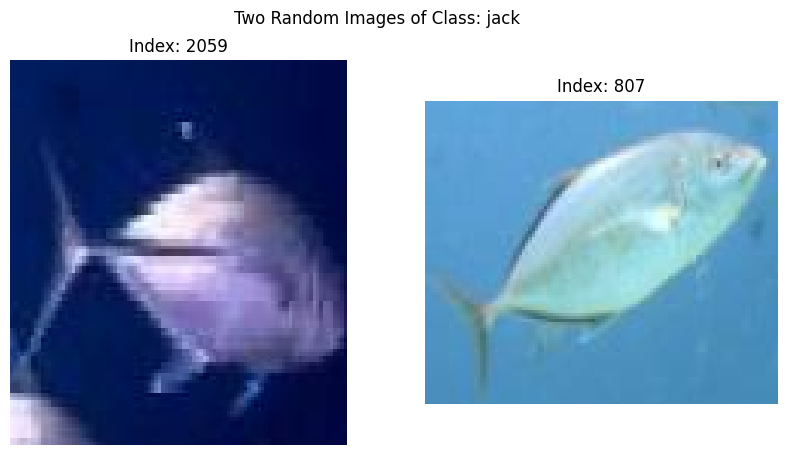

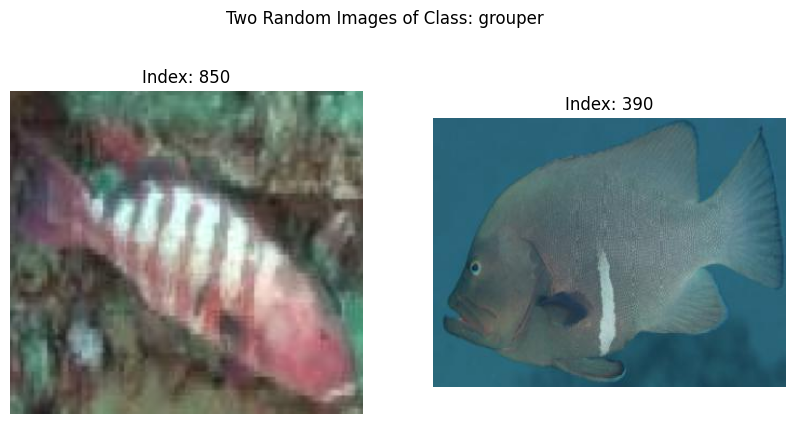

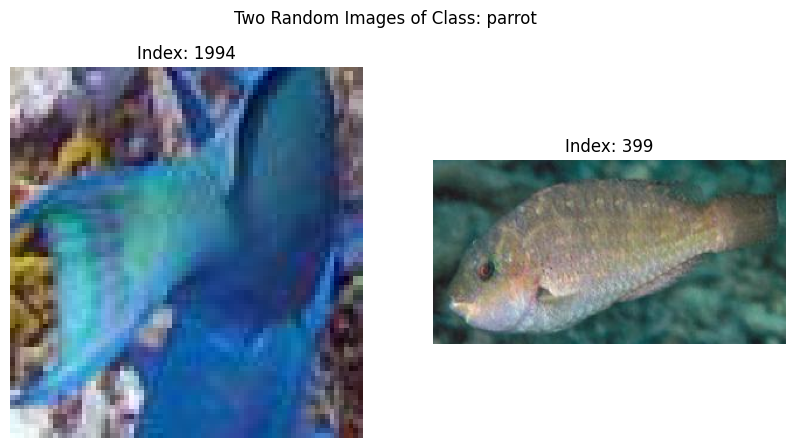

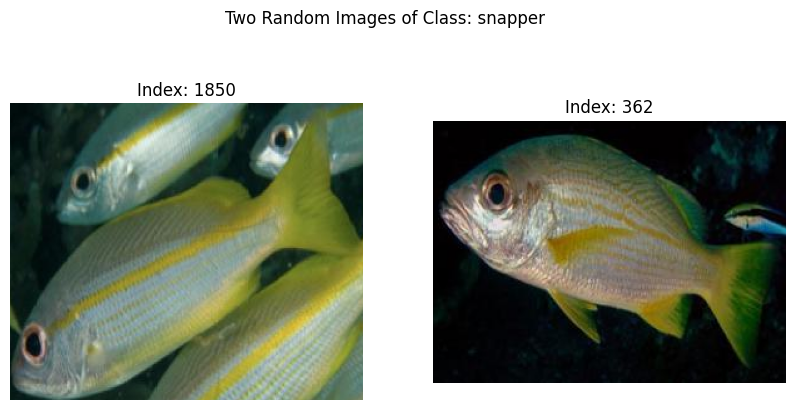

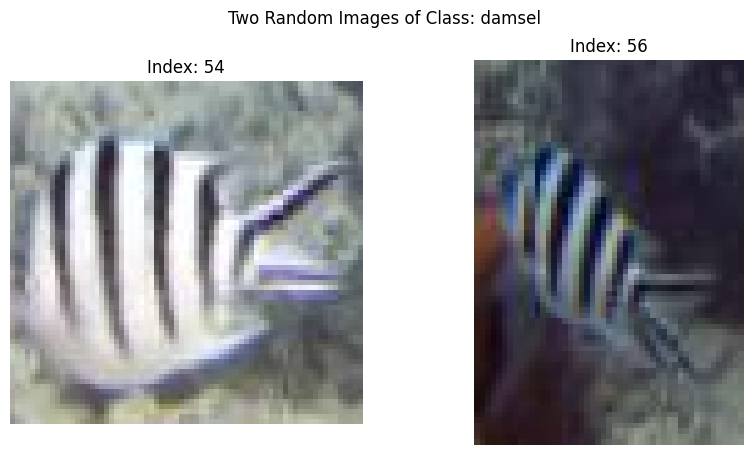

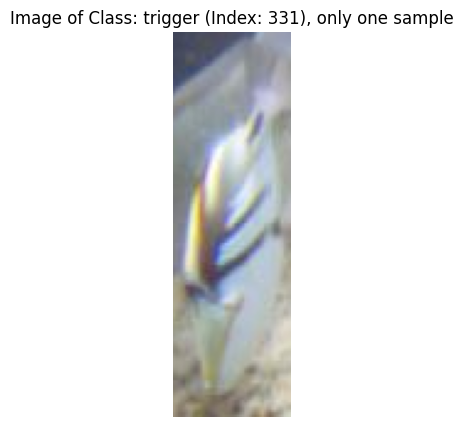

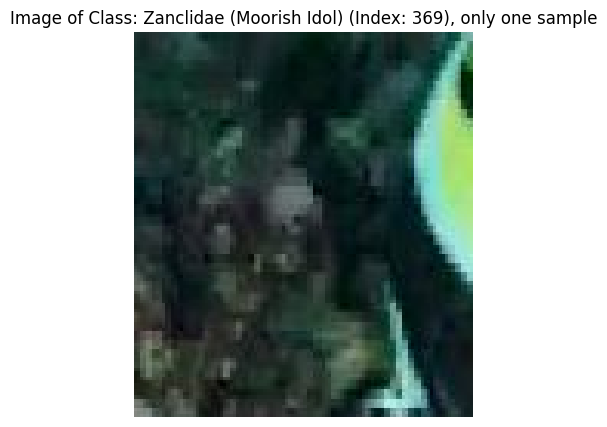

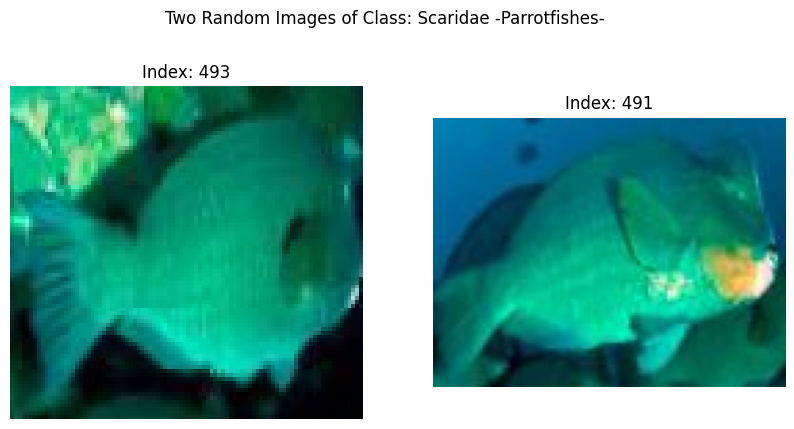

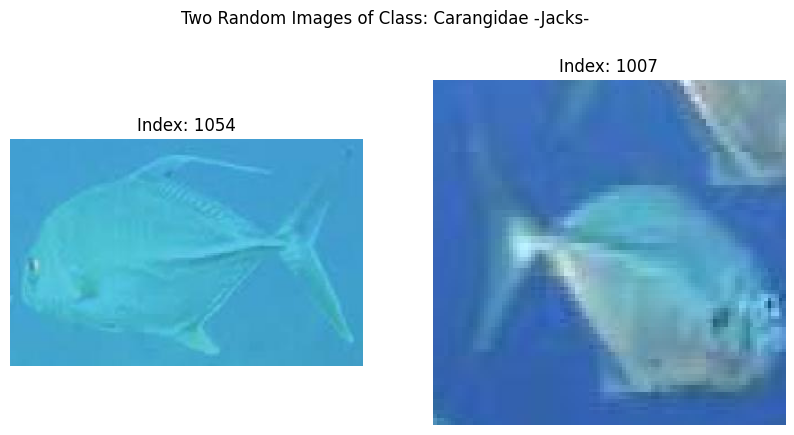

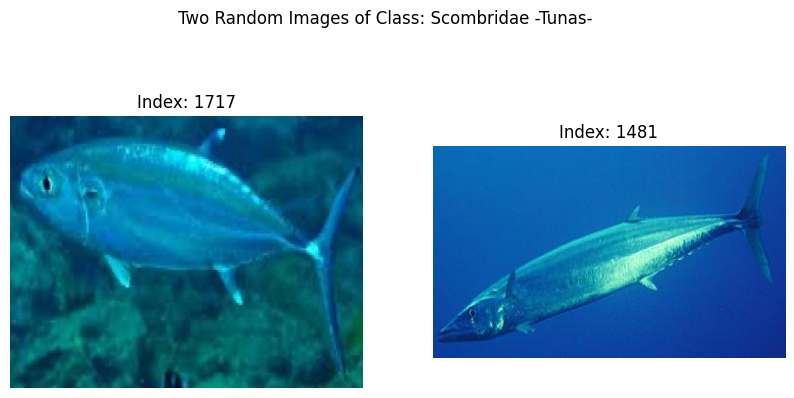

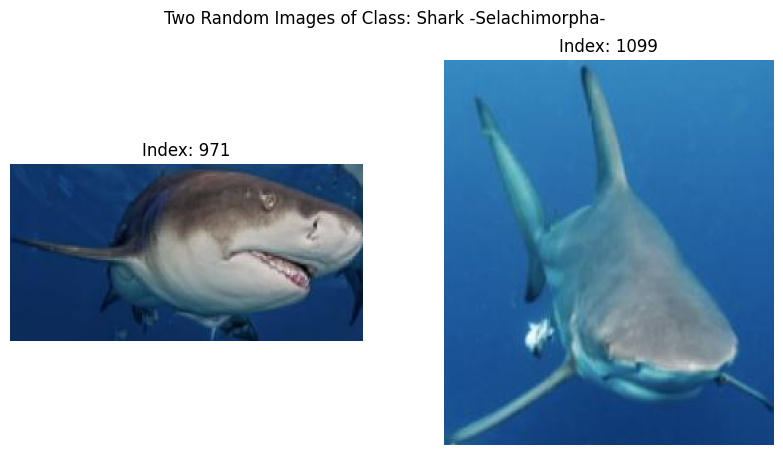

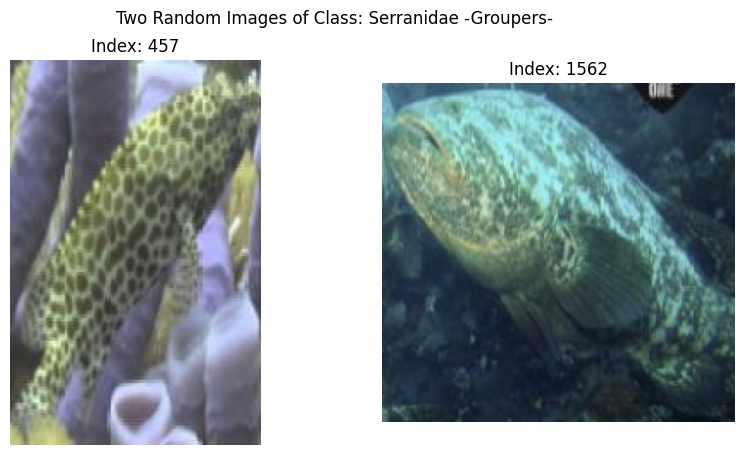

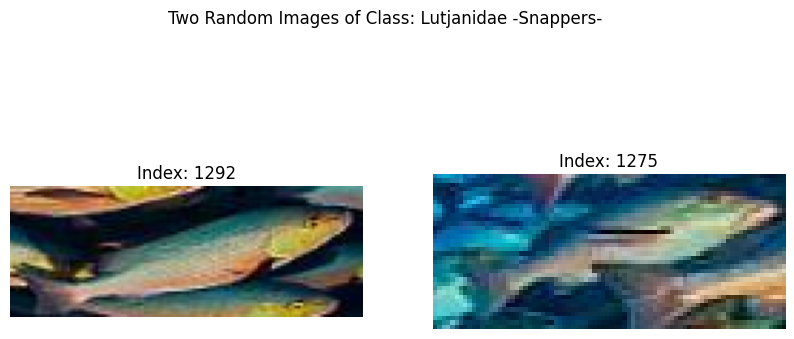

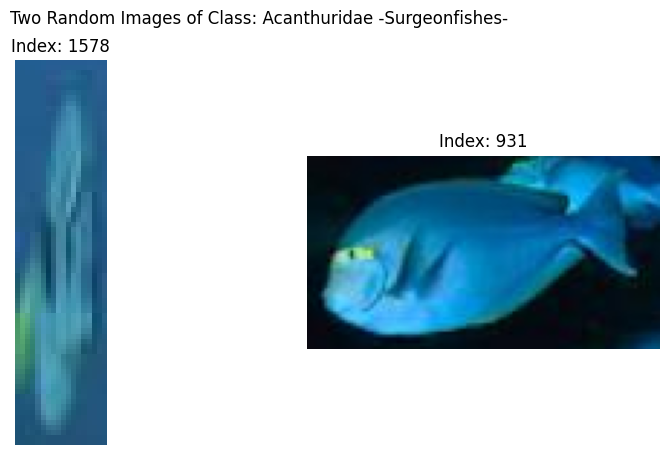

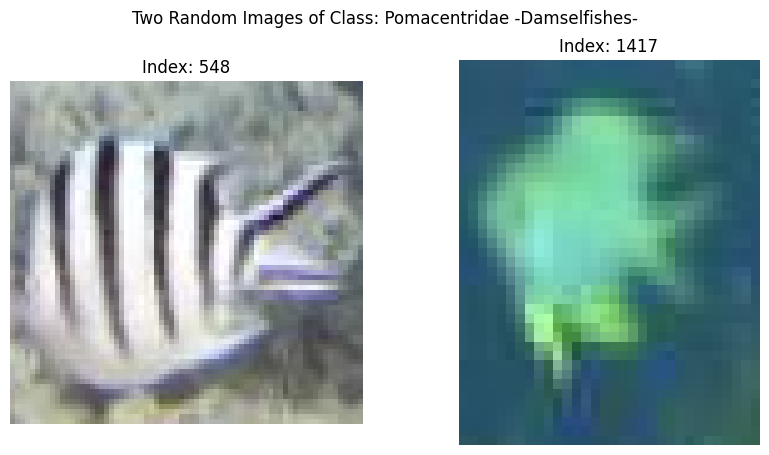

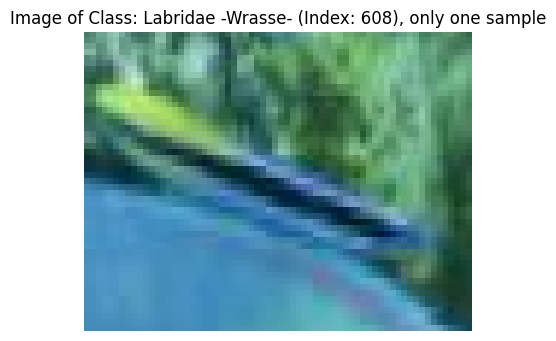

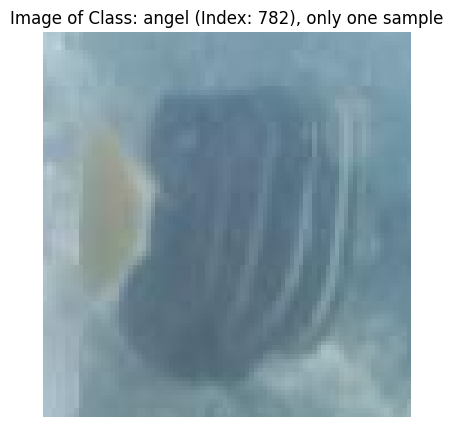

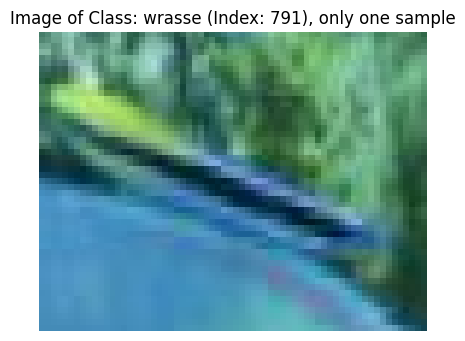

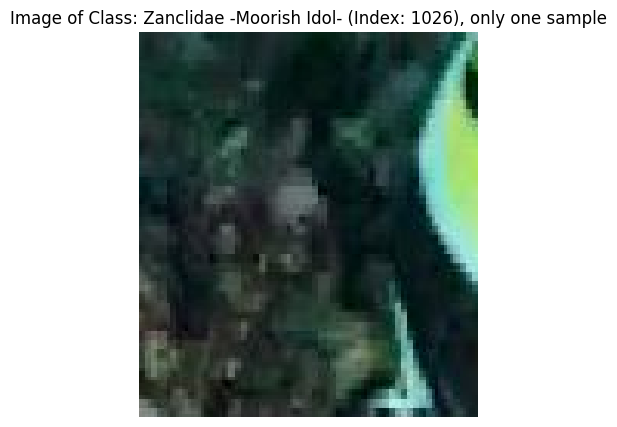

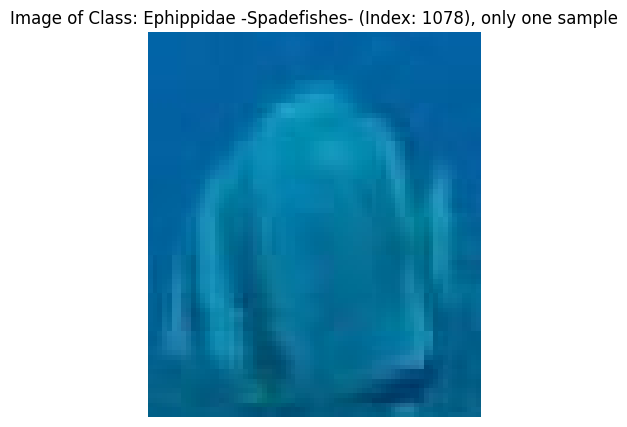

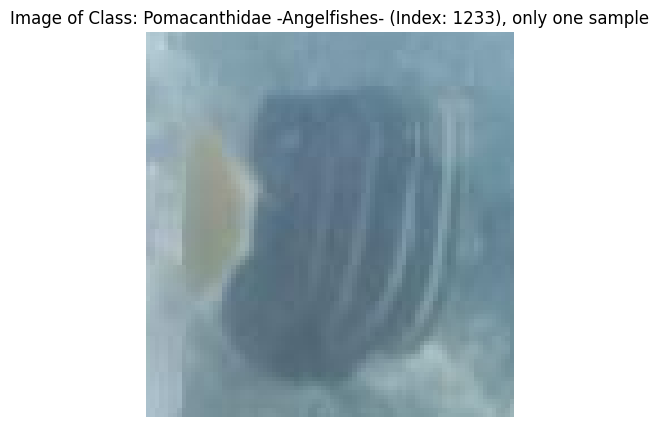

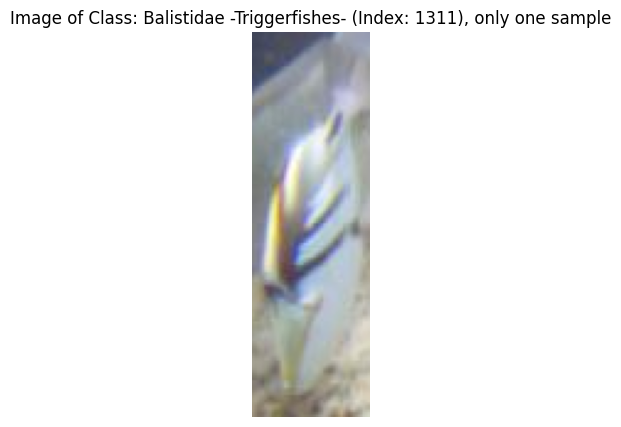

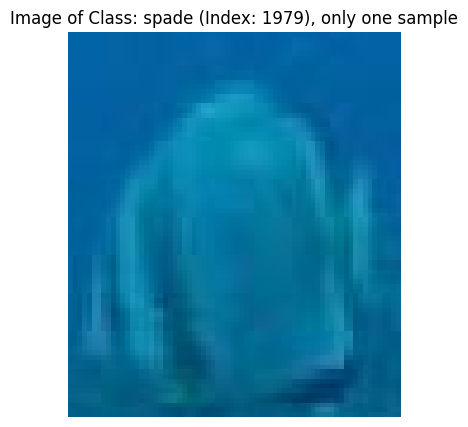

In [2]:
# Read the CSV file into a DataFrame
df_train = pd.read_csv('data/train/_annotations.csv')

# Read and store cropped images
cropped_image_list = []

for index, row in df_train.iterrows():
    image_path = row['filename']
    image = Image.open('data/train/' + image_path)

    # Extract cropping coordinates
    xmin, ymin, xmax, ymax = (
        max(0, row['xmin']),
        max(0, row['ymin']),
        min(image.width, row['xmax']),
        min(image.height, row['ymax'])
    )

    # Check if the adjusted coordinates are valid
    if xmin < xmax and ymin < ymax:
        # Crop the image
        cropped_image = np.array(image.crop((xmin, ymin, xmax, ymax)))

        # Store the cropped image in the list
        cropped_image_list.append(cropped_image)
    else:
        # If the coordinates are invalid, append a placeholder (e.g., None)
        cropped_image_list.append(None)

# Add a new column to the DataFrame with cropped images
df_train['cropped_image'] = cropped_image_list

# Filter out rows with None values in the 'cropped_image' column
df_valid_crops = df_train.dropna(subset=['cropped_image'])

# Display general information
print("Number of valid cropped images:", len(df_valid_crops))
print("Number of proposed images:", len(df_train))
print("Image sizes:")
print(df_valid_crops['cropped_image'].apply(lambda x: x.shape).value_counts())

# Get unique classes in the DataFrame
unique_classes = df_valid_crops['class'].unique()

# Number of random images to plot for each class
images_to_plot = 2

# Plot two random images for each class
for class_name in unique_classes:
    # Filter DataFrame based on the current class
    df_same_class = df_valid_crops[df_valid_crops['class'] == class_name]

    # Check the number of images in the current class
    num_images = len(df_same_class)

    if num_images >= images_to_plot:
        # Randomly select two images from the current class
        random_indices = random.sample(df_same_class.index.tolist(), images_to_plot)

        # Plot the two random images for the current class
        fig, axes = plt.subplots(1, images_to_plot, figsize=(10, 5))
        fig.suptitle(f'Two Random Images of Class: {class_name}')

        for i, ax in enumerate(axes):
            ax.imshow(df_same_class.loc[random_indices[i]]['cropped_image'])
            ax.set_title(f"Index: {random_indices[i]}")
            ax.axis('off')

        plt.show()
        
    elif num_images == 1:
        # Plot the single image for the current class
        plt.figure(figsize=(5, 5))
        plt.imshow(df_same_class.iloc[0]['cropped_image'])
        plt.title(f'Image of Class: {class_name} (Index: {df_same_class.index[0]}), only one sample')
        plt.axis('off')
        plt.show()
    else:
        print(f"No images of class '{class_name}' for plotting.")


We can see that some of the classes are the same but with different name and that some of the picture are very pixelized. So we are going to do some mapping for the classes and create a function to automate the recuperation of the data. We can also see that due to the cropping the image are all of different size so after we are going to resize them into the same size the biggest one

In [3]:
unique_classes

array(['tuna', 'surgeon', 'shark', 'jack', 'grouper', 'parrot', 'snapper',
       'damsel', 'trigger', 'Zanclidae (Moorish Idol)',
       'Scaridae -Parrotfishes-', 'Carangidae -Jacks-',
       'Scombridae -Tunas-', 'Shark -Selachimorpha-',
       'Serranidae -Groupers-', 'Lutjanidae -Snappers-',
       'Acanthuridae -Surgeonfishes-', 'Pomacentridae -Damselfishes-',
       'Labridae -Wrasse-', 'angel', 'wrasse', 'Zanclidae -Moorish Idol-',
       'Ephippidae -Spadefishes-', 'Pomacanthidae -Angelfishes-',
       'Balistidae -Triggerfishes-', 'spade'], dtype=object)

In [4]:
old_class_to_actual_class = {
    'tuna' : 'tuna', 
    'surgeon': 'surgeon', 
    'shark': 'shark', 
    'jack': 'jack', 
    'grouper': 'grouper', 
    'parrot': 'parrot', 
    'snapper': 'snapper',
    'damsel': 'damsel', 
    'trigger': 'trigger', 
    'Zanclidae (Moorish Idol)': 'moorish idol',
    'Scaridae -Parrotfishes-': 'parrot', 
    'Carangidae -Jacks-': 'jack',
    'Scombridae -Tunas-': 'tuna', 
    'Shark -Selachimorpha-': 'shark',
    'Serranidae -Groupers-': 'grouper', 
    'Lutjanidae -Snappers-': 'snapper',
    'Acanthuridae -Surgeonfishes-': 'surgeon', 
    'Pomacentridae -Damselfishes-': 'damsel',
    'Labridae -Wrasse-': 'wrasse', 
    'angel': 'angel', 
    'wrasse': 'wrasse', 
    'Zanclidae -Moorish Idol-': 'moorish idol',
    'Ephippidae -Spadefishes-': 'spade', 
    'Pomacanthidae -Angelfishes-': 'angel',
    'Balistidae -Triggerfishes-': 'trigger', 
    'spade': 'spade'
}

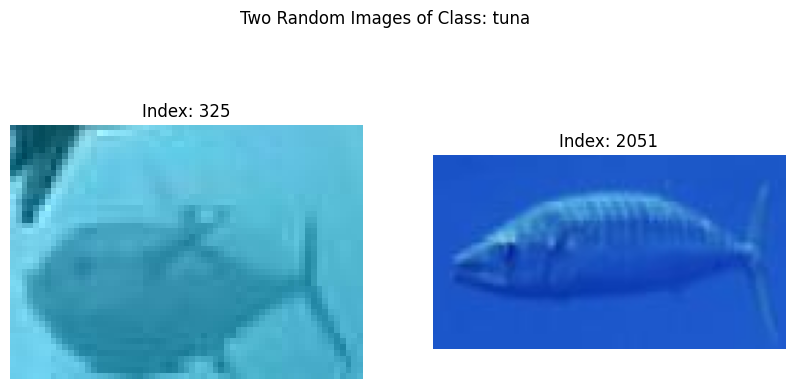

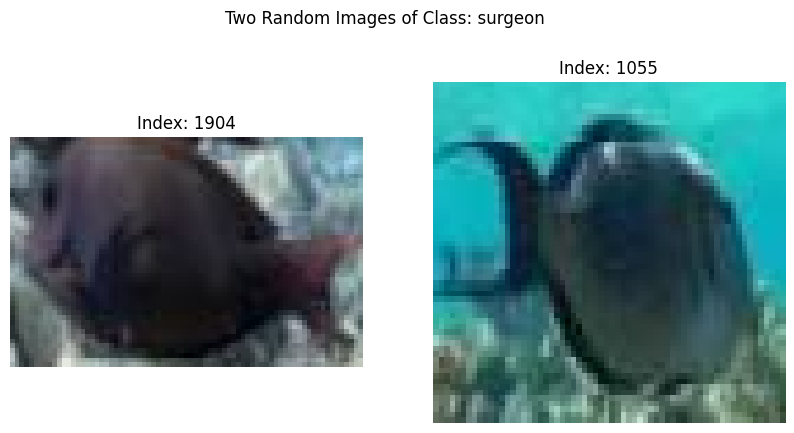

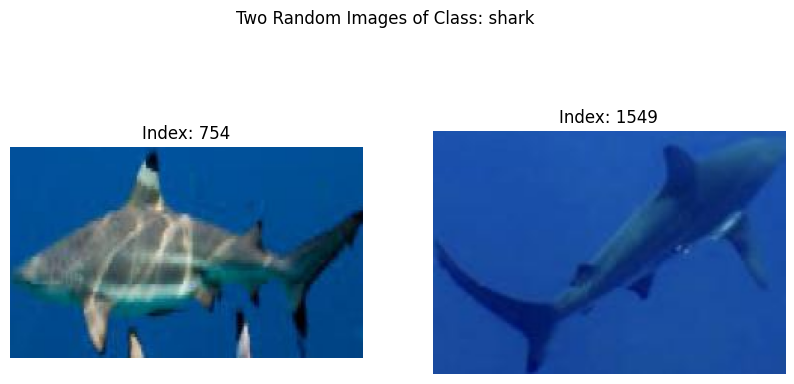

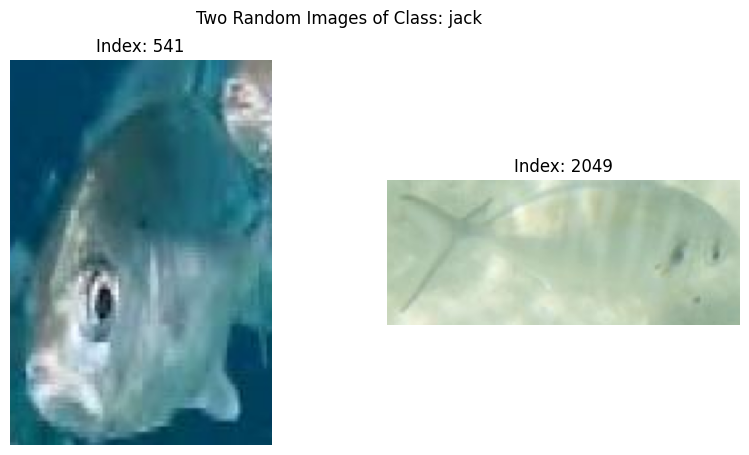

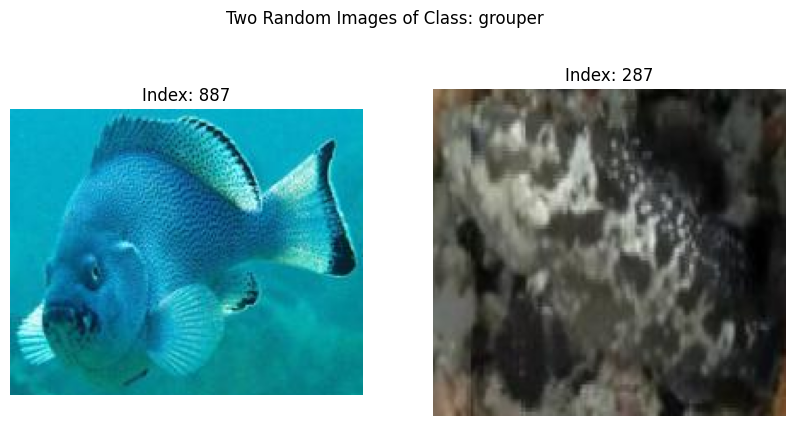

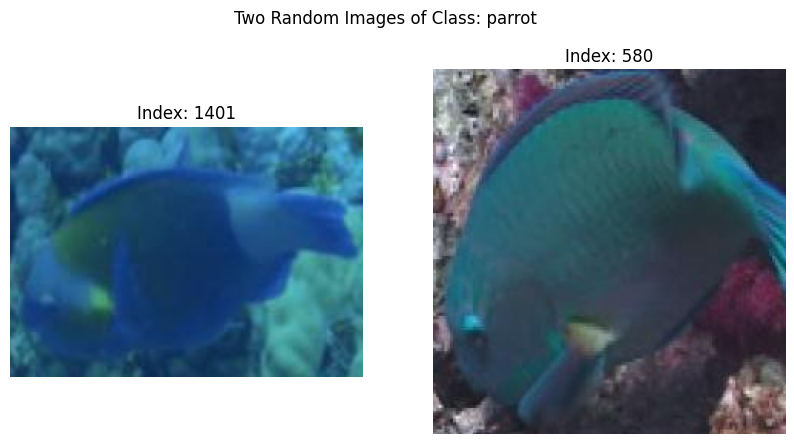

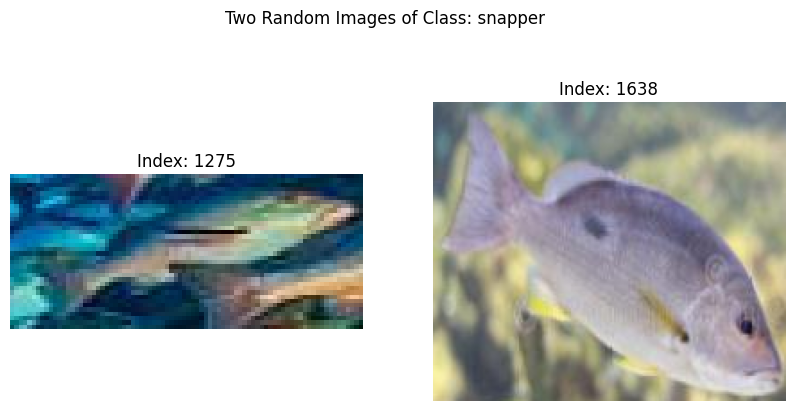

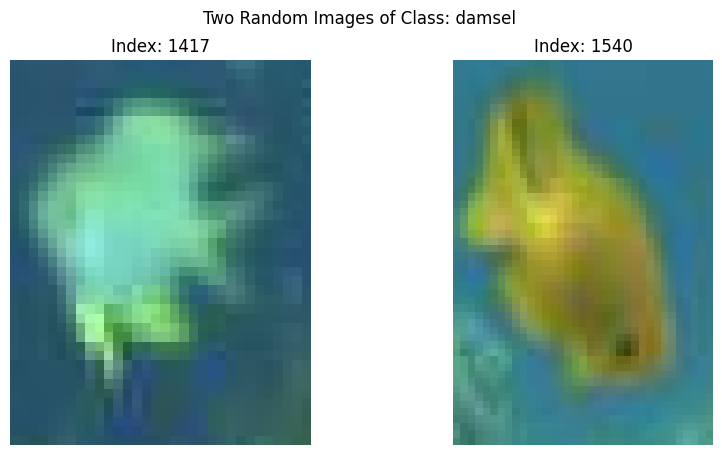

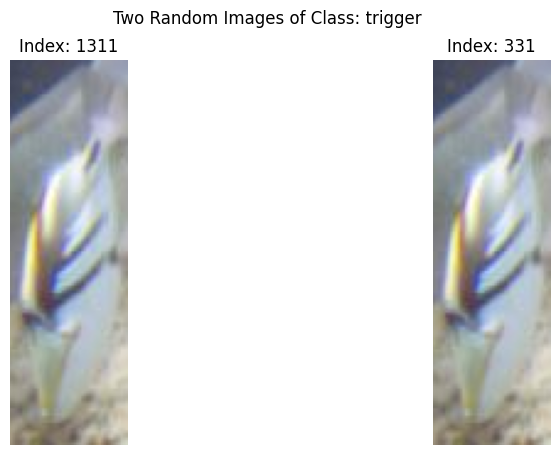

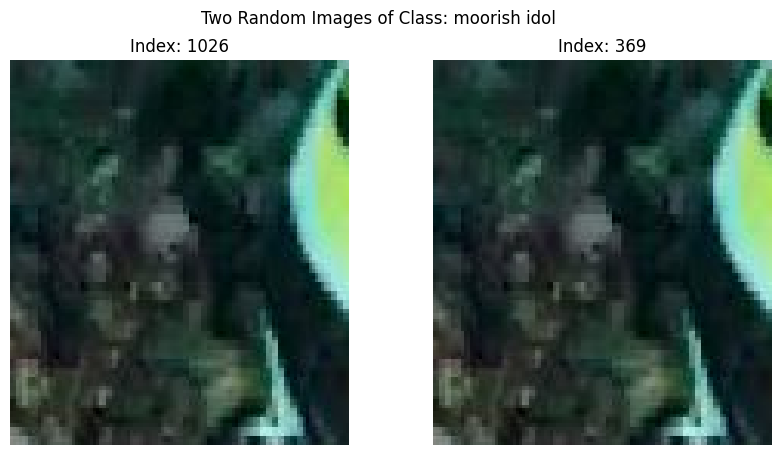

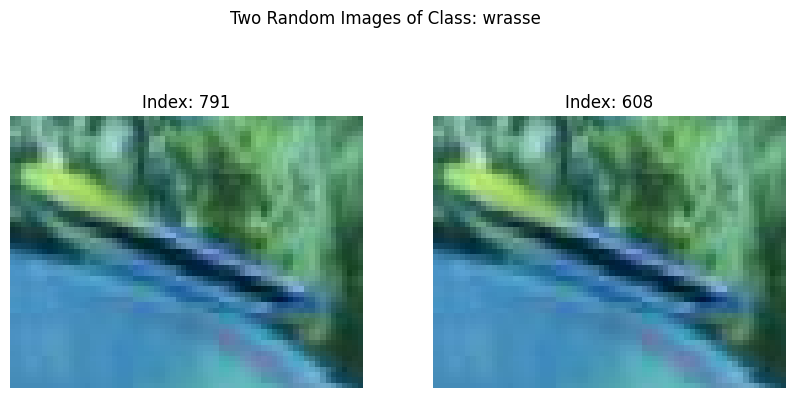

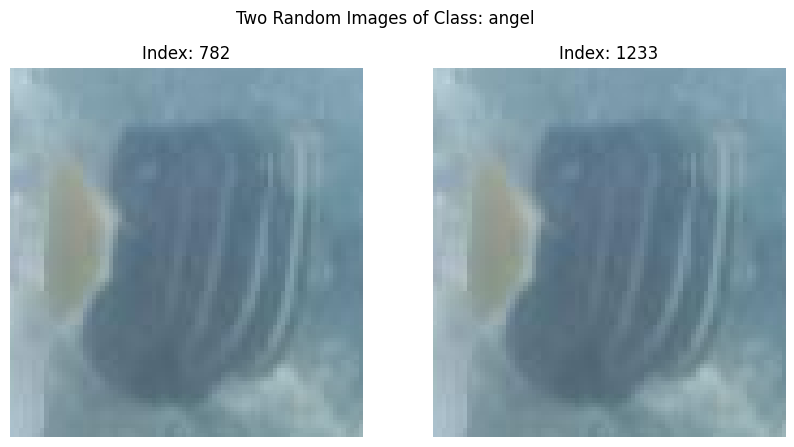

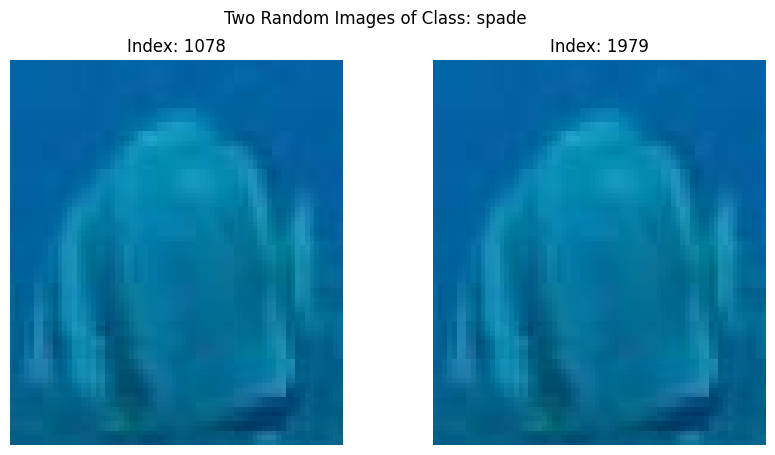

In [5]:
# Copy valid dataframe 
df_new_class = df_valid_crops.copy()

# Replace old class names with new class names
df_new_class['class'] = df_new_class['class'].replace(old_class_to_actual_class)

# Get unique classes in the DataFrame
unique_classes = df_new_class['class'].unique()

# Number of random images to plot for each class
images_to_plot = 2

# Plot two random images for each class
for class_name in unique_classes:
    # Filter DataFrame based on the current class
    df_same_class = df_new_class[df_new_class['class'] == class_name]

    # Check the number of images in the current class
    num_images = len(df_same_class)

    if num_images >= images_to_plot:
        # Randomly select two images from the current class
        random_indices = random.sample(df_same_class.index.tolist(), images_to_plot)

        # Plot the two random images for the current class
        fig, axes = plt.subplots(1, images_to_plot, figsize=(10, 5))
        fig.suptitle(f'Two Random Images of Class: {class_name}')

        for i, ax in enumerate(axes):
            ax.imshow(df_same_class.loc[random_indices[i]]['cropped_image'])
            ax.set_title(f"Index: {random_indices[i]}")
            ax.axis('off')

        plt.show()
    elif num_images == 1:
        # Plot the single image for the current class
        plt.figure(figsize=(5, 5))
        plt.imshow(df_same_class.iloc[0]['cropped_image'])
        plt.title(f'Image of Class: {class_name} (Index: {df_same_class.index[0]}), only one sample')
        plt.axis('off')
        plt.show()
    else:
        print(f"No images of class '{class_name}' for plotting.")

In [6]:
df_new_class['class'].value_counts()

surgeon         534
jack            376
tuna            333
snapper         299
shark           188
parrot          176
grouper         147
damsel           12
trigger           2
moorish idol      2
wrasse            2
angel             2
spade             2
Name: class, dtype: int64

We can see that there is some of the data which is underreepresented as told in the website 

We are now going to look at the size of the images and reshape them

In [7]:
df_valid_crops['cropped_image'].apply(lambda x: x.shape).value_counts().sort_index()

(2, 1, 3)        4
(18, 27, 3)      2
(19, 25, 3)      2
(23, 26, 3)      2
(24, 27, 3)      2
                ..
(402, 388, 3)    2
(406, 291, 3)    2
(409, 363, 3)    2
(410, 334, 3)    2
(411, 415, 3)    2
Name: cropped_image, Length: 1023, dtype: int64

In [8]:
# looking at the average image size
index = df_valid_crops['cropped_image'].apply(lambda x: x.shape).value_counts().sort_index().index

# Convert tuples to arrays
index_as_arrays = np.array([np.array(x) for x in index])

# Transpose the array to have dimensions in the order (height, width, channels)
index_transposed = index_as_arrays.transpose()

# Calculate the average along each dimension
average_size = np.mean(index_transposed, axis=1)

print(average_size)

[137.51808407 171.09384164   3.        ]


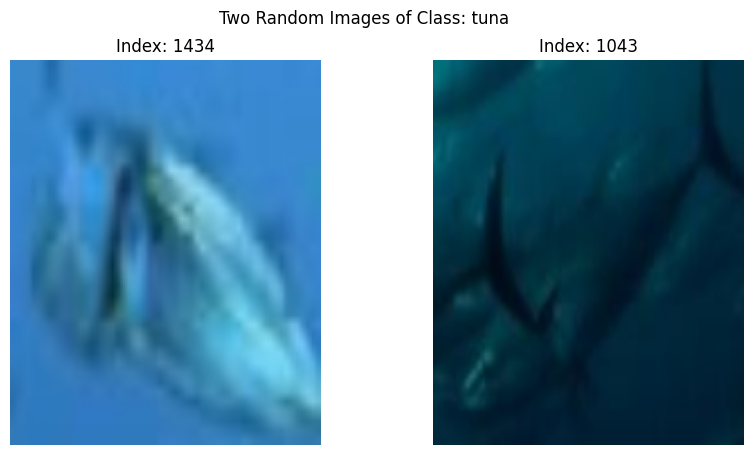

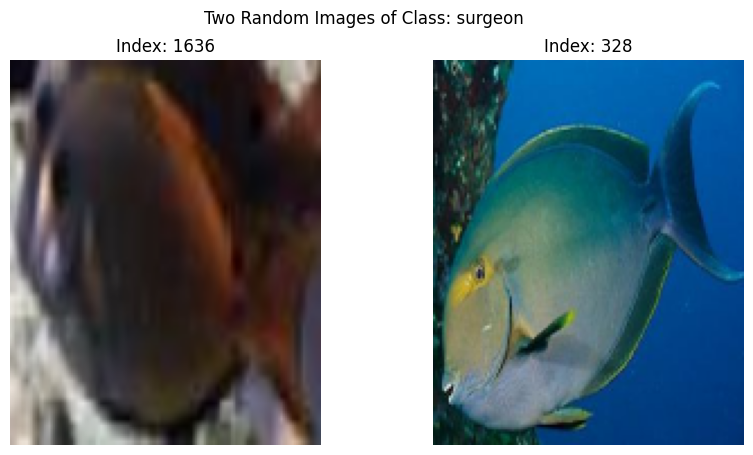

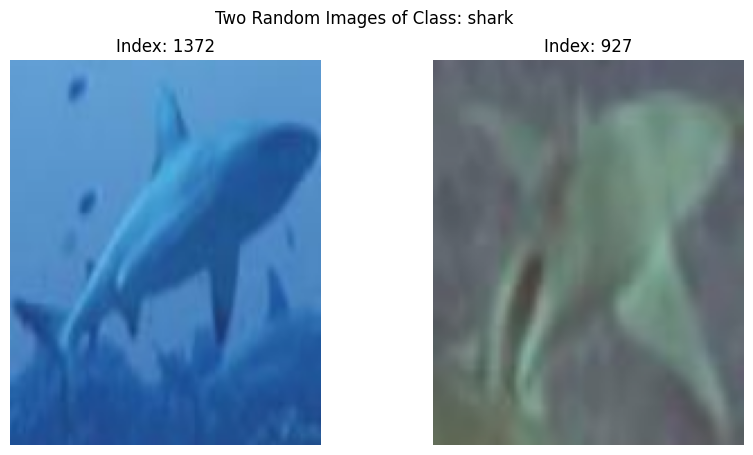

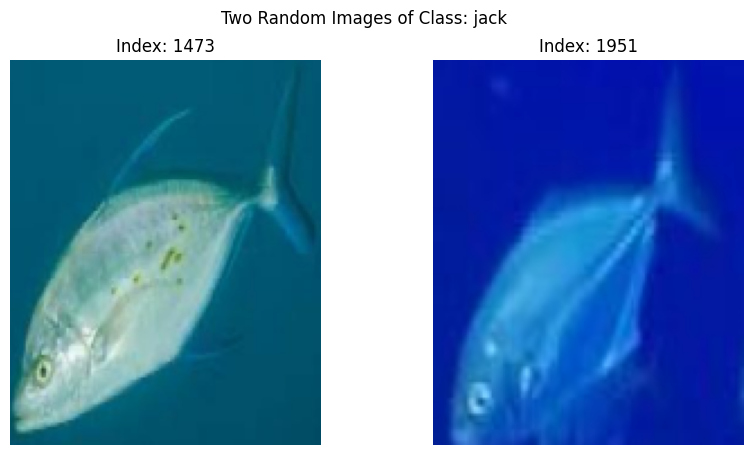

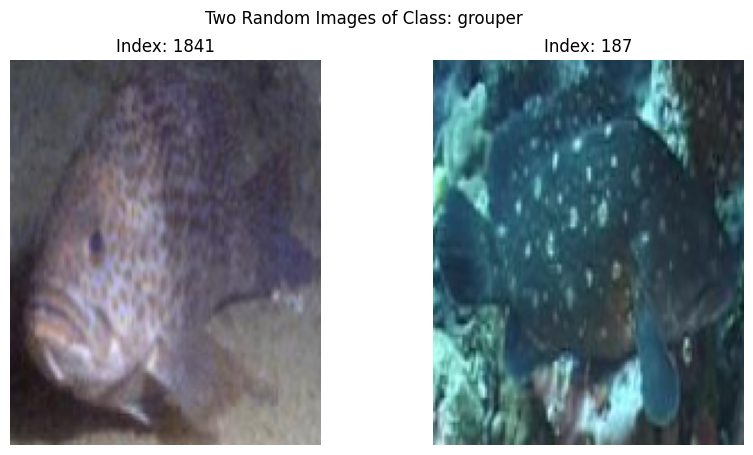

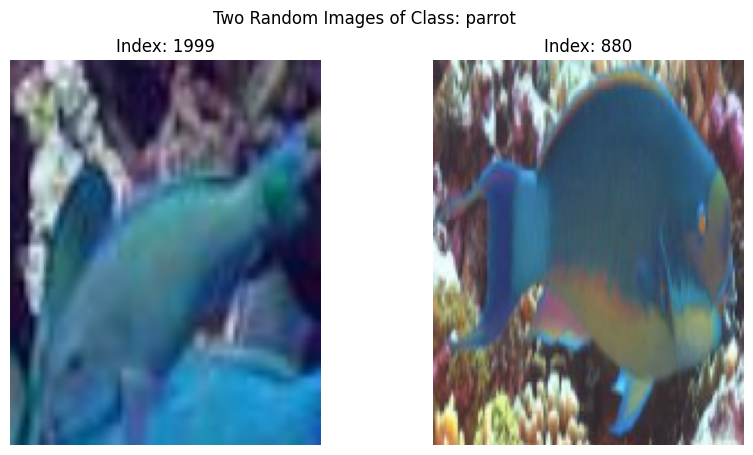

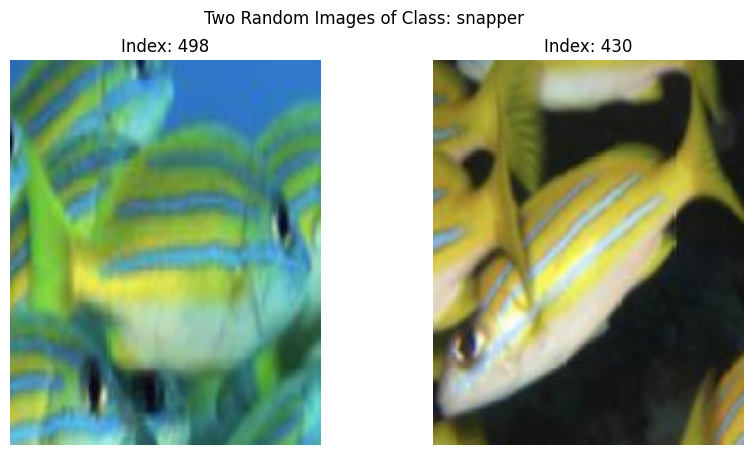

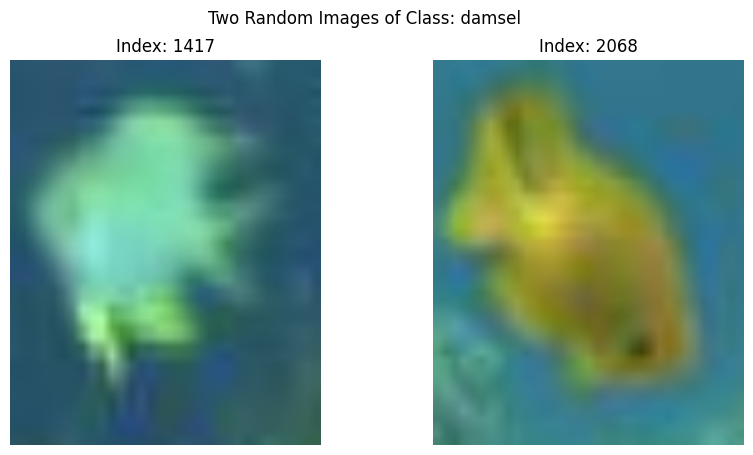

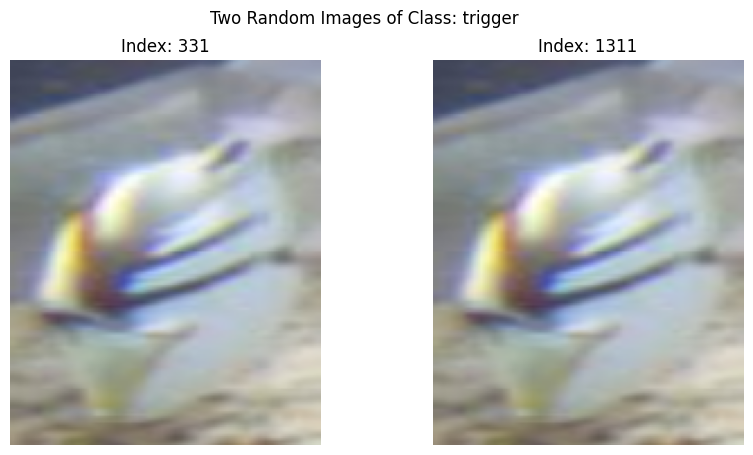

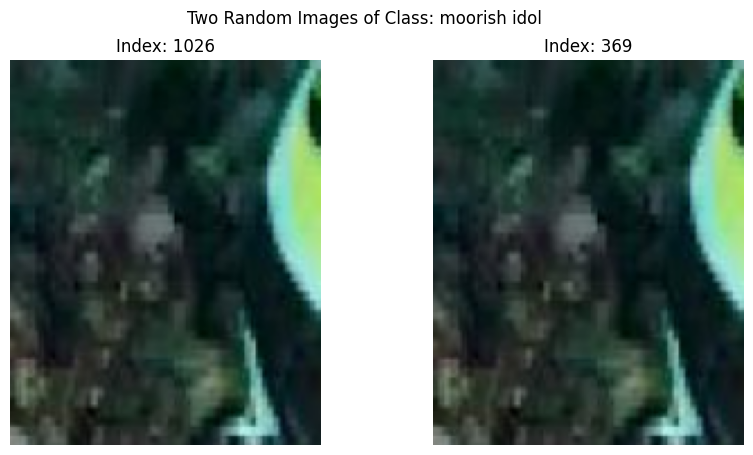

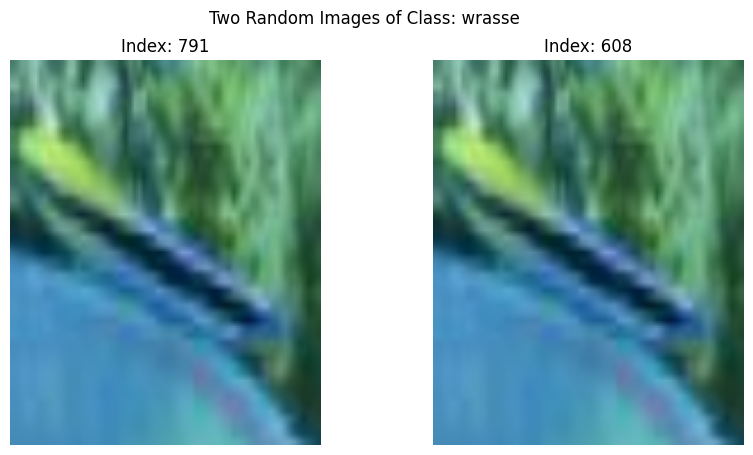

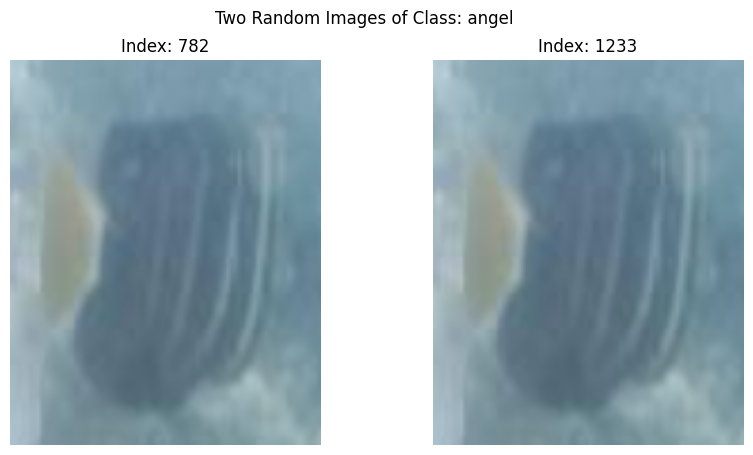

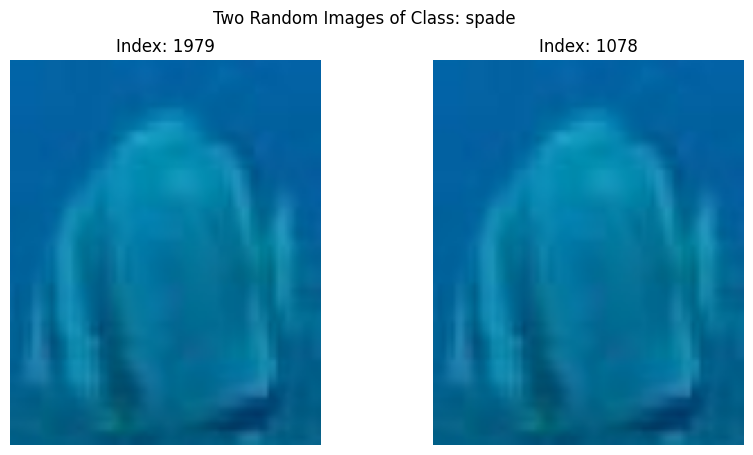

In [9]:
# Define the target size for resizing
target_size = (138, 171)  

# Reshape the images in the 'cropped_image' column
df_new_class['cropped_image'] = df_new_class['cropped_image'].apply(lambda x: cv2.resize(x, target_size) if x is not None else None)

# Get unique classes in the DataFrame
unique_classes = df_new_class['class'].unique()

# Number of random images to plot for each class
images_to_plot = 2

# Plot two random images for each class
for class_name in unique_classes:
    # Filter DataFrame based on the current class
    df_same_class = df_new_class[df_new_class['class'] == class_name]

    # Check the number of images in the current class
    num_images = len(df_same_class)

    if num_images >= images_to_plot:
        # Randomly select two images from the current class
        random_indices = random.sample(df_same_class.index.tolist(), images_to_plot)

        # Plot the two random images for the current class
        fig, axes = plt.subplots(1, images_to_plot, figsize=(10, 5))
        fig.suptitle(f'Two Random Images of Class: {class_name}')

        for i, ax in enumerate(axes):
            ax.imshow(df_same_class.loc[random_indices[i]]['cropped_image'])
            ax.set_title(f"Index: {random_indices[i]}")
            ax.axis('off')

        plt.show()
    elif num_images == 1:
        # Plot the single image for the current class
        plt.figure(figsize=(5, 5))
        plt.imshow(df_same_class.iloc[0]['cropped_image'])
        plt.title(f'Image of Class: {class_name} (Index: {df_same_class.index[0]}), only one sample')
        plt.axis('off')
        plt.show()
    else:
        print(f"No images of class '{class_name}' for plotting.")

### Functions for crop 

In [10]:
def read_and_crop(path):
    
    # Read the CSV file into a DataFrame
    if path[-1] == '/':
        df = pd.read_csv(path +'_annotations.csv')
    else :
        df = pd.read_csv(path +'/_annotations.csv')

    # Read and store cropped images
    cropped_image_list = []

    for index, row in df.iterrows():
        image_path = row['filename']
        if path[-1] == '/':
            image = Image.open(path + image_path)
        else :
            image = Image.open(path + '/' + image_path)
            

        # Extract cropping coordinates
        xmin, ymin, xmax, ymax = (
            max(0, row['xmin']),
            max(0, row['ymin']),
            min(image.width, row['xmax']),
            min(image.height, row['ymax'])
        )

        # Check if the adjusted coordinates are valid
        if xmin < xmax and ymin < ymax:
            
            # Crop the image
            cropped_image = np.array(image.crop((xmin, ymin, xmax, ymax))) 

            # Reshape the images in the 'cropped_image' column
            cropped_reshape_image = cv2.resize(cropped_image, (171, 138))

            # Store the cropped image in the list
            cropped_image_list.append(cropped_reshape_image)
        else:
            # If the coordinates are invalid, append a placeholder (e.g., None)
            cropped_image_list.append(None)

    # Add a new column to the DataFrame with cropped images
    df['cropped_image'] = cropped_image_list.copy()

    # Filter out rows with None values in the 'cropped_image' column
    df_valid_crops = df.dropna(subset=['cropped_image']).copy()
    
    df_final = df_valid_crops[['class', 'cropped_image']].copy()
    
    # 
    old_class_to_actual_class = {
        'tuna' : 'tuna', 
        'surgeon': 'surgeon', 
        'shark': 'shark', 
        'jack': 'jack', 
        'grouper': 'grouper', 
        'parrot': 'parrot', 
        'snapper': 'snapper',
        'damsel': 'damsel', 
        'trigger': 'trigger', 
        'Zanclidae (Moorish Idol)': 'moorish idol',
        'Scaridae -Parrotfishes-': 'parrot', 
        'Carangidae -Jacks-': 'jack',
        'Scombridae -Tunas-': 'tuna', 
        'Shark -Selachimorpha-': 'shark',
        'Serranidae -Groupers-': 'grouper', 
        'Lutjanidae -Snappers-': 'snapper',
        'Acanthuridae -Surgeonfishes-': 'surgeon', 
        'Pomacentridae -Damselfishes-': 'damsel',
        'Labridae -Wrasse-': 'wrasse', 
        'angel': 'angel', 
        'wrasse': 'wrasse', 
        'Zanclidae -Moorish Idol-': 'moorish idol',
        'Ephippidae -Spadefishes-': 'spade', 
        'Pomacanthidae -Angelfishes-': 'angel',
        'Balistidae -Triggerfishes-': 'trigger', 
        'spade': 'spade'
    }
   
    # Replace old class names with new class names
    df_final['class'] = df_final['class'].replace(old_class_to_actual_class)
    
    return df_final


def print_image_by_classes(df,images_to_plot=2):
    
    # Get unique classes in the DataFrame
    unique_classes = df['class'].unique()

    # Plot two random images for each class
    for class_name in unique_classes:
        # Filter DataFrame based on the current class
        df_same_class = df[df['class'] == class_name]

        # Check the number of images in the current class
        num_images = len(df_same_class)

        if num_images >= images_to_plot:
            # Randomly select two images from the current class
            random_indices = random.sample(df_same_class.index.tolist(), images_to_plot)

            # Plot the two random images for the current class
            fig, axes = plt.subplots(1, images_to_plot, figsize=(10, 5))
            fig.suptitle(f'Two Random Images of Class: {class_name}')

            for i, ax in enumerate(axes):
                ax.imshow(df_same_class.loc[random_indices[i]]['cropped_image'])
                ax.set_title(f"Index: {random_indices[i]}")
                ax.axis('off')

            plt.show()
            continue
            
        elif num_images >= 1:
            # Plot the single image for the current class
            plt.figure(figsize=(5, 5))
            plt.imshow(df_same_class.iloc[0]['cropped_image'])
            plt.title(f'Image of Class: {class_name} (Index: {df_same_class.index[0]})')
            plt.axis('off')
            plt.show()
            continue
            
        else:
            print(f"No images of class '{class_name}' for plotting.")
    

In [11]:
# function to ressort the X and y of dataframe
def to_work(df):
    
    class_to_number = {
    'tuna': 0, 
    'surgeon': 1, 
    'shark': 2, 
    'jack': 3, 
    'grouper': 4, 
    'parrot': 5, 
    'snapper': 6,
    'damsel': 7, 
    'trigger': 8, 
    'moorish idol': 9, 
    'wrasse': 10, 
    'angel': 11, 
    'spade': 12
}

    X = np.stack(df['cropped_image'].to_numpy().copy(), axis=0)
    
    # standardize and center data (make my pc crash)
    X = (X / 255) - 0.5
    
    y = df['class'].replace(class_to_number).to_numpy().copy()
    y_cat = to_categorical(y, num_classes=13)  
    
    return X, y, y_cat 

In [12]:
df_train = read_and_crop('data/train/')
df_test = read_and_crop('data/test/')
df_valid = read_and_crop('data/valid/')

### Classification

#### Création du modèle

In [12]:
def init_model():
    
    # Start by creating a sequential model
    model = models.Sequential()
    
    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(8, (4, 4), activation='relu', padding='same', input_shape=(138, 171, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    ### Second Convolution & MaxPoolingialize
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer
    model.add(layers.Dense(10, activation='relu'))
    # droupout to minimise the overfitting
    model.add(layers.Dropout(0.3))
    ### Last layer - Classification Layer
    model.add(layers.Dense(13, activation='softmax')) # softmax for multiclass classification

    ### Model compilation
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'Precision','Recall'])
    
    return model
    

#### Entrainement et Evaluation du modele

In [13]:
# to plot the result
def plot_history(history):
    fig, axs = plt.subplots(4,1, figsize=(10,10))
    
    axs[0].plot(history.history['loss'], color='red', label='train')
    axs[0].plot(history.history['val_loss'], color='blue', label='val')
    axs[0].set_title('Loss')
    axs[0].legend(['train', 'test'],loc="upper right")
    
    axs[1].plot(history.history['accuracy'], color='red', label='train')
    axs[1].plot(history.history['val_accuracy'], color='blue', label='val')
    axs[1].set_title('Accuracy ')
    axs[1].legend(['train', 'test'],loc="upper right")

    axs[2].plot(history.history['precision'], color='red', label='train')
    axs[2].plot(history.history['val_precision'], color='blue', label='val')
    axs[2].set_title('Precision ')
    axs[2].legend(['train', 'test'],loc="upper right")

    axs[3].plot(history.history['recall'], color='red', label='train')
    axs[3].plot(history.history['val_recall'], color='blue', label='val')
    axs[3].set_title('Recall')
    axs[3].legend(['train', 'test'],loc="upper right")
    

    for ax in axs.flat:
        ax.set(xlabel='Epoch', ylabel='')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        
    plt.show()

In [14]:
X_train, y_train, y_train_cat = to_work(df_train)
X_test, y_test, y_test_cat = to_work(df_test)
X_val, y_val, y_val_cat = to_work(df_valid)

ValueError: all input arrays must have the same shape




------------------------------------------Batch Size 4------------------------------------------


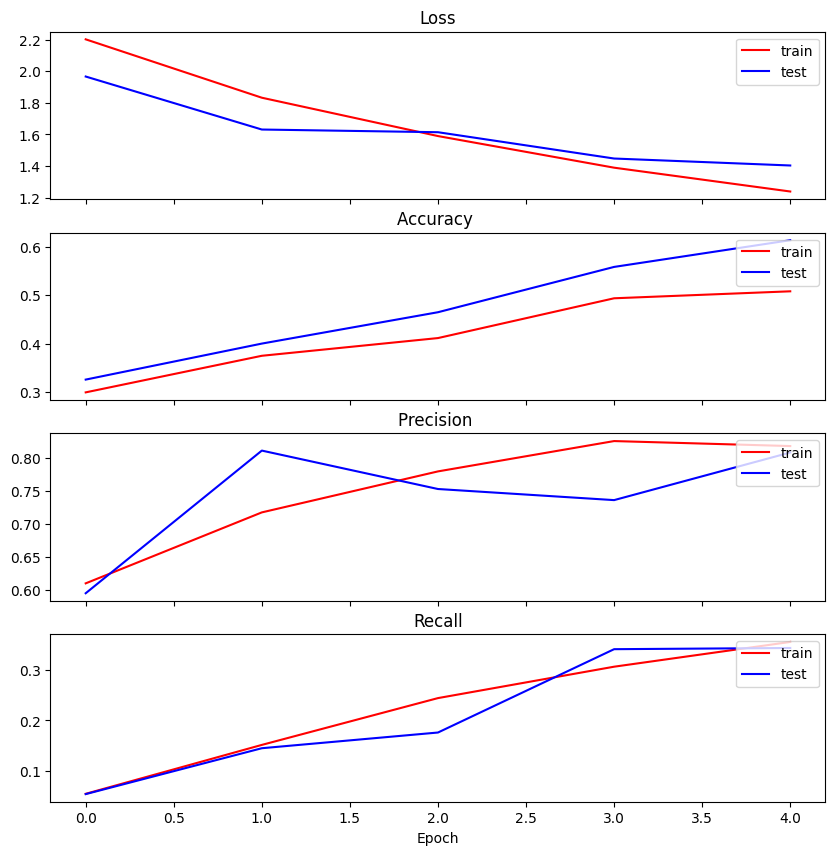

         Model Evaluation on Training :
     Training Loss:     0.9835358262062073
   Training Accuracy:   0.7243373394012451
  Training Precision:   0.9400599598884583
    Training Recall:    0.45349398255348206 

         Model Evaluation on Validation :
    Validation Loss:    1.9076452255249023
  Validation Accuracy:  0.38556066155433655
 Validation Precision:  0.6108108162879944
   Validation Recall:   0.1735791116952896
------------------------------------------Batch Size 16------------------------------------------


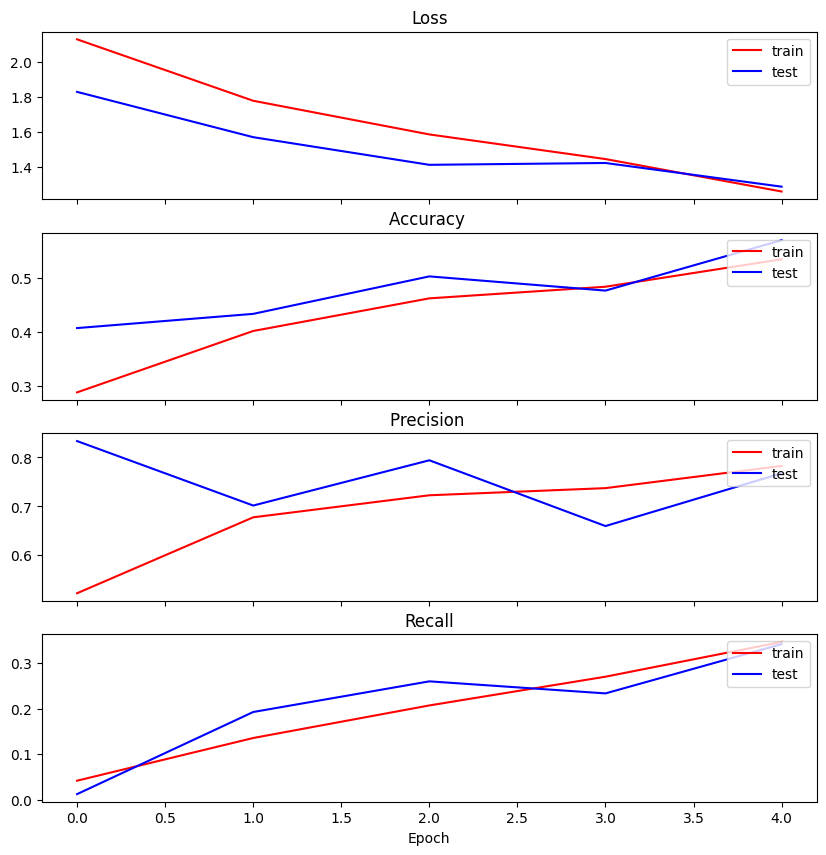

         Model Evaluation on Training :
     Training Loss:     1.0051698684692383
   Training Accuracy:   0.6973493695259094
  Training Precision:   0.9097586274147034
    Training Recall:    0.41783133149147034 

         Model Evaluation on Validation :
    Validation Loss:    1.7289073467254639
  Validation Accuracy:  0.43317973613739014
 Validation Precision:  0.557603657245636
   Validation Recall:   0.18586789071559906
------------------------------------------Batch Size 32------------------------------------------


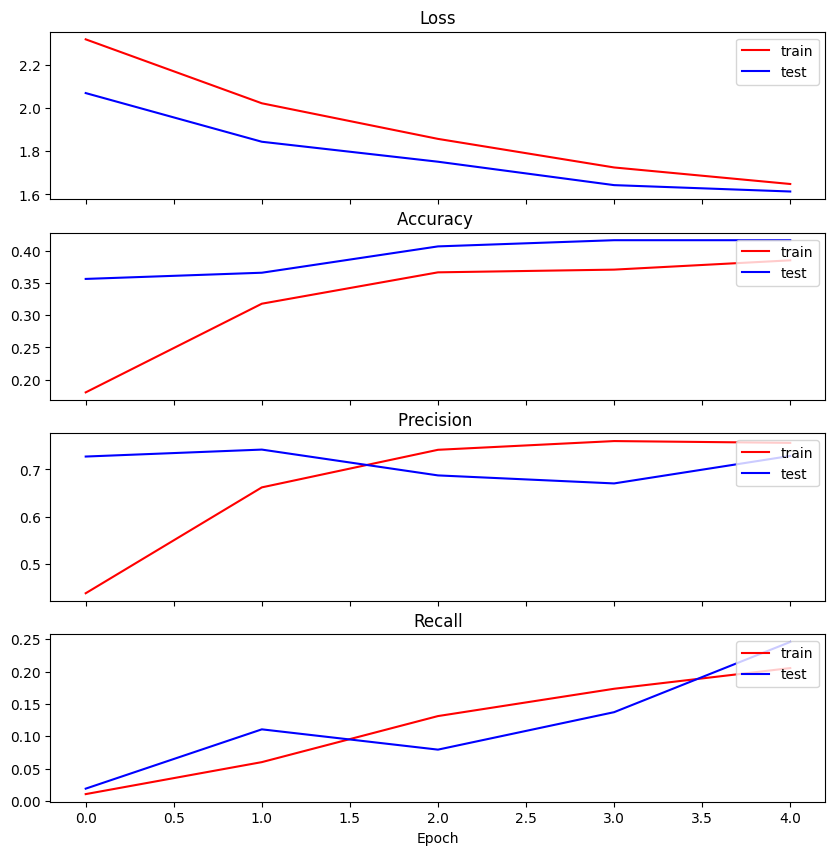

         Model Evaluation on Training :
     Training Loss:     1.3737008571624756
   Training Accuracy:   0.5045782923698425
  Training Precision:   0.796169638633728
    Training Recall:    0.2804819345474243 

         Model Evaluation on Validation :
    Validation Loss:    1.7481063604354858
  Validation Accuracy:  0.37634408473968506
 Validation Precision:  0.5829596519470215
   Validation Recall:   0.19969278573989868
------------------------------------------Batch Size 64------------------------------------------


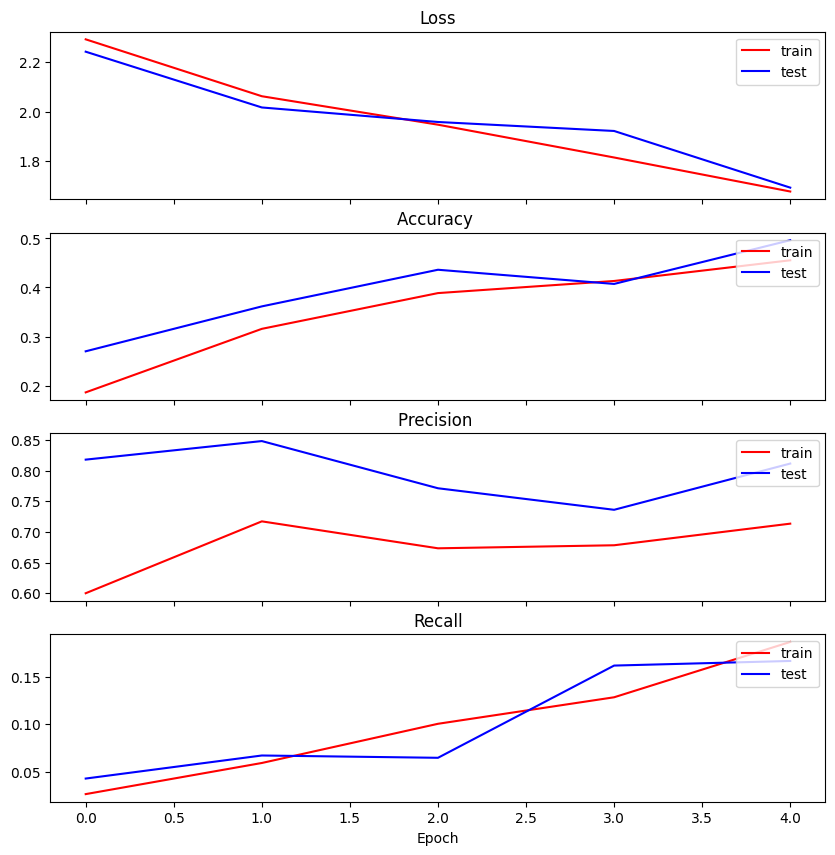

         Model Evaluation on Training :
     Training Loss:     1.4573103189468384
   Training Accuracy:   0.5860241055488586
  Training Precision:   0.8962264060974121
    Training Recall:    0.18313252925872803 

         Model Evaluation on Validation :
    Validation Loss:    1.8822168111801147
  Validation Accuracy:  0.36866360902786255
 Validation Precision:  0.6666666865348816
   Validation Recall:   0.10445468872785568


In [16]:
# to save the models & the metrics
models_cnn = {}

# early stopping critera
es = EarlyStopping(patience=20, restore_best_weights=True)

for batch in [4,16,32,64] :
    
    model = init_model()
    
    history = model.fit(
        X_train,
        y_train_cat,
        validation_split=0.2,
        epochs = 5,
        batch_size = batch, 
        verbose = 0, 
        callbacks = [es]
    )
    
    print(f'------------------------------------------Batch Size {batch}------------------------------------------')
    
    # store the model
    models_cnn[batch] = model
        
    # plot the history of loss and accuracy
    plot_history(history)
    
    # print the evaluation of the model:
    trainEval = model.evaluate(X_train,y_train_cat, verbose=0)
    valEval = model.evaluate(X_val,y_val_cat, verbose=0)

    print("         Model Evaluation on Training :")
    print("     Training Loss:    ", trainEval[0])
    print("   Training Accuracy:  ", trainEval[1])
    print("  Training Precision:  ", trainEval[2])
    print("    Training Recall:   ", trainEval[3], '\n')
    print("         Model Evaluation on Validation :")
    print("    Validation Loss:   ", valEval[0])
    print("  Validation Accuracy: ", valEval[1])
    print(" Validation Precision: ", valEval[2])
    print("   Validation Recall:  ", valEval[3])

## 2) Transfer Learning

## VGG16

In [15]:
from tensorflow.keras.applications import VGG16

def init_model_with_pretrained_base(base_model):
    base_model.trainable = False  # Geler les couches du modèle pré-entraîné

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(13, activation='softmax')  # Adaptez à votre nombre de classes
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall'])
    
    return model

# Chargement de VGG16 comme base
base_model_vgg16 = VGG16(include_top=False, input_shape=(138, 171, 3), weights='imagenet')

# Initialisation du modèle avec VGG16 comme base
model_vgg16 = init_model_with_pretrained_base(base_model_vgg16)


In [16]:
# Initialisation du modèle VGG16
model_vgg16 = init_model_with_pretrained_base(base_model_vgg16)


# Entraînement
history_vgg16 = model_vgg16.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Évaluation
plot_history(history_vgg16)

# print the evaluation of the model:
trainEval = model_vgg16.evaluate(X_train,y_train_cat, verbose=0)
valEval = model_vgg16.evaluate(X_val,y_val_cat, verbose=0)

print("         Model Evaluation on Training :")
print("     Training Loss:    ", trainEval[0])
print("   Training Accuracy:  ", trainEval[1])
print("  Training Precision:  ", trainEval[2])
print("    Training Recall:   ", trainEval[3], '\n')
print("         Model Evaluation on Validation :")
print("    Validation Loss:   ", valEval[0])
print("  Validation Accuracy: ", valEval[1])
print(" Validation Precision: ", valEval[2])
print("   Validation Recall:  ", valEval[3])

NameError: name 'X_train' is not defined

Avantages

- Haute précision et performance: atteignant une précision d'entraînement de 95.66% et une précision de validation de 66.97%.
- Amélioration constante des métriques: Les métriques telles que la précision, la précision et le rappel ont toutes montré des améliorations constantes, indiquant que le modèle apprend efficacement à partir des données.

Inconvénients

- Temps d'entraînement plus long: Avec des temps d'étape d'environ 70 à 77 secondes, VGG16 peut être considéré comme ayant un temps d'entraînement relativement long par rapport aux autres modèles.


## ResNet50

Epoch 1/10
52/52 [==============================] - 48s 809ms/step - loss: 3.7696 - accuracy: 0.1849 - precision: 0.1565 - recall: 0.0325 - val_loss: 2.0821 - val_accuracy: 0.2530 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
52/52 [==============================] - 39s 756ms/step - loss: 2.2136 - accuracy: 0.2084 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.0094 - val_accuracy: 0.2410 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
52/52 [==============================] - 39s 749ms/step - loss: 2.1337 - accuracy: 0.2175 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.9917 - val_accuracy: 0.2386 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
52/52 [==============================] - 40s 778ms/step - loss: 2.1085 - accuracy: 0.2241 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.9706 - val_accuracy: 0.2506 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
52/52 [==========================

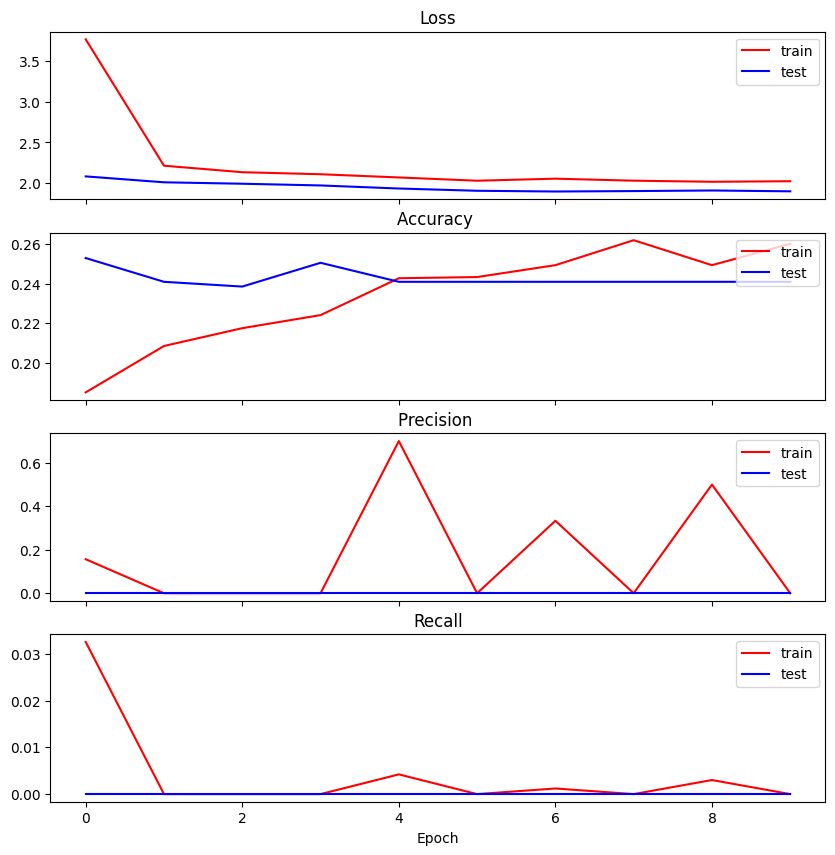

         Model Evaluation on Training :
     Training Loss:     1.8716387748718262
   Training Accuracy:   0.2573494017124176
  Training Precision:   0.0
    Training Recall:    0.0 

         Model Evaluation on Validation :
    Validation Loss:    1.8612816333770752
  Validation Accuracy:  0.3317972421646118
 Validation Precision:  0.0
   Validation Recall:   0.0


In [19]:
from tensorflow.keras.applications import ResNet50

base_model_resnet50 = ResNet50(include_top=False, input_shape=(138, 171, 3), weights='imagenet')
model_resnet50 = init_model_with_pretrained_base(base_model_resnet50)



# Chargement de ResNet50 comme base
base_model_resnet50 = ResNet50(include_top=False, input_shape=(138, 171, 3), weights='imagenet')

# Initialisation du modèle avec ResNet50
model_resnet50 = init_model_with_pretrained_base(base_model_resnet50)

# Entraînement
history_resnet50 = model_resnet50.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=10,  
    batch_size=32,
    verbose=1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Évaluation
plot_history(history_resnet50)

# print the evaluation of the model:
trainEval = model_resnet50.evaluate(X_train,y_train_cat, verbose=0)
valEval = model_resnet50.evaluate(X_val,y_val_cat, verbose=0)

print("         Model Evaluation on Training :")
print("     Training Loss:    ", trainEval[0])
print("   Training Accuracy:  ", trainEval[1])
print("  Training Precision:  ", trainEval[2])
print("    Training Recall:   ", trainEval[3], '\n')
print("         Model Evaluation on Validation :")
print("    Validation Loss:   ", valEval[0])
print("  Validation Accuracy: ", valEval[1])
print(" Validation Precision: ", valEval[2])
print("   Validation Recall:  ", valEval[3])

Avantages

- Architecture résiduelle: L'utilisation de connexions résiduelles aide à lutter contre le problème de disparition du gradient, permettant d'entraîner des réseaux plus profonds.
- Efficacité du temps d'entraînement: Avec des temps d'étape autour de 39 à 41 secondes, ResNet50 est plus de 2X plus rapide à l'entraînement que VGG16.

Inconvénients

- Faible performance: Le modèle a montré une faible performance sur les métriques d'évaluation, avec une précision d'entraînement de seulement 25.73% et une précision de validation encore plus faible.
- Absence d'apprentissage: Le modèle n'a pas amélioré ses prédictions au-delà du hasard, comme en témoignent les précisions et rappels nuls sur les données de validation.

=> Ne convient pas à nos données

## EfficientNet

In [20]:
from tensorflow.keras.applications import EfficientNetB5

def init_model_with_efficientnet():
    base_model = EfficientNetB5(include_top=False, weights='imagenet', input_shape=(138, 171, 3))
    base_model.trainable = False  

    # Création du modèle
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(13, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall'])
    
    return model


Epoch 1/10
52/52 [==============================] - 89s 1s/step - loss: 2.0568 - accuracy: 0.2187 - precision: 0.2586 - recall: 0.0181 - val_loss: 2.0223 - val_accuracy: 0.2506 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
52/52 [==============================] - 61s 1s/step - loss: 1.9333 - accuracy: 0.2536 - precision: 0.2400 - recall: 0.0036 - val_loss: 1.9354 - val_accuracy: 0.2458 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
52/52 [==============================] - 62s 1s/step - loss: 1.9236 - accuracy: 0.2633 - precision: 0.2727 - recall: 0.0018 - val_loss: 1.9281 - val_accuracy: 0.2410 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
52/52 [==============================] - 61s 1s/step - loss: 1.9025 - accuracy: 0.2663 - precision: 0.3750 - recall: 0.0054 - val_loss: 1.9037 - val_accuracy: 0.2578 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
52/52 [==============================] - 61s 1s/step - loss: 1.8990 -

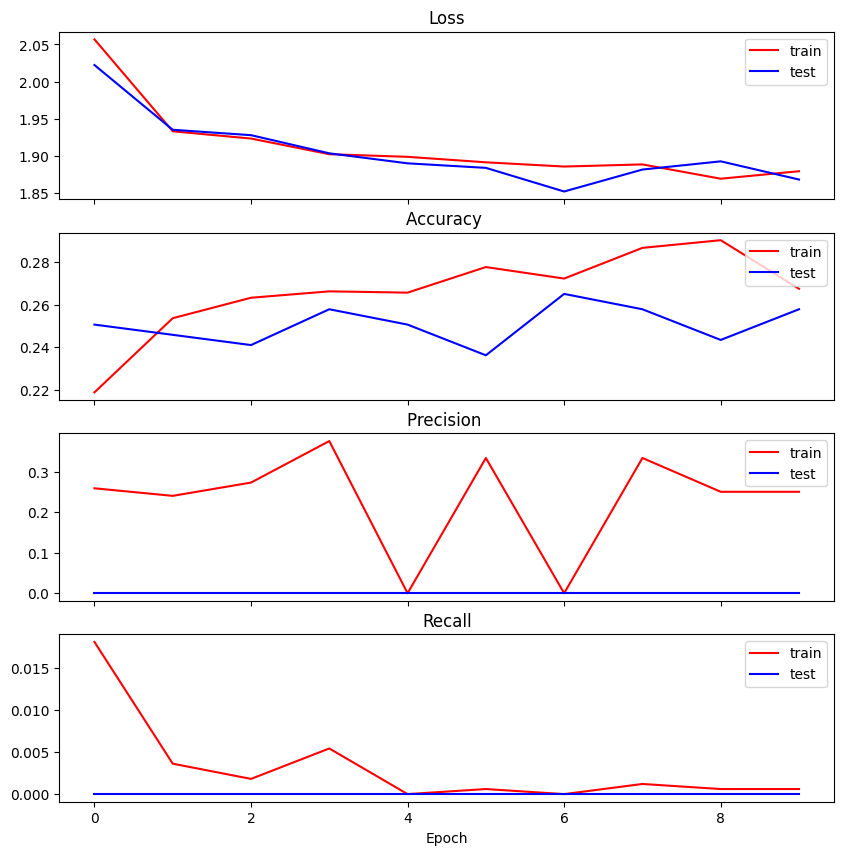

         Model Evaluation on Training :
     Training Loss:     1.8451253175735474
   Training Accuracy:   0.278554230928421
  Training Precision:   0.0
    Training Recall:    0.0 

         Model Evaluation on Validation :
    Validation Loss:    1.9042847156524658
  Validation Accuracy:  0.2872503697872162
 Validation Precision:  0.0
   Validation Recall:   0.0


In [21]:
# Initialisation du modèle avec EfficientNet
model_efficientnet = init_model_with_efficientnet()

# Entraînement
history_efficientnet = model_efficientnet.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=10,  # Ajustez selon vos besoins
    batch_size=32,
    verbose=1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Évaluation
plot_history(history_efficientnet)

# print the evaluation of the model:
trainEval = model_efficientnet.evaluate(X_train,y_train_cat, verbose=0)
valEval = model_efficientnet.evaluate(X_val,y_val_cat, verbose=0)

print("         Model Evaluation on Training :")
print("     Training Loss:    ", trainEval[0])
print("   Training Accuracy:  ", trainEval[1])
print("  Training Precision:  ", trainEval[2])
print("    Training Recall:   ", trainEval[3], '\n')
print("         Model Evaluation on Validation :")
print("    Validation Loss:   ", valEval[0])
print("  Validation Accuracy: ", valEval[1])
print(" Validation Precision: ", valEval[2])
print("   Validation Recall:  ", valEval[3])

Avantages

- Équilibrage des dimensions du modèle: EfficientNet utilise une approche systématique pour équilibrer la largeur, la profondeur et la résolution du réseau, ce qui peut conduire à une efficacité accrue.
- Amélioration progressive: Bien que partant de performances initiales basses, le modèle montre une amélioration au fil des époques, suggérant une capacité d'apprentissage.

Inconvénients

- Performances basses: Le modèle commence avec des performances relativement basses, ce qui peut nécessiter plus de temps ou des ajustements pour atteindre une performance acceptable.
- Complexité de l'architecture: L'équilibrage des facteurs de dimensionnement peut rendre l'architecture plus complexe à ajuster et à optimiser par rapport à des modèles plus simples.

=> Le modèle ne convenait pas bien à notre jeu de donnée ou à cause de sa compléxité nous n'avons pas trouvé comment le régler.

### MobileNetV2

In [22]:
from tensorflow.keras.applications import MobileNetV2

def init_model_with_mobilenetV2():
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(138, 171, 3))
    base_model.trainable = False  # Gel des couches du modèle pré-entraîné

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(13, activation='softmax')  # Adaptez en fonction du nombre de vos classes
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall'])
    
    return model


Epoch 1/10
52/52 [==============================] - 17s 246ms/step - loss: 1.0394 - accuracy: 0.6855 - precision: 0.7621 - recall: 0.6349 - val_loss: 0.5344 - val_accuracy: 0.8096 - val_precision: 0.8649 - val_recall: 0.7711
Epoch 2/10
52/52 [==============================] - 10s 202ms/step - loss: 0.2982 - accuracy: 0.9072 - precision: 0.9337 - recall: 0.8910 - val_loss: 0.4087 - val_accuracy: 0.8627 - val_precision: 0.8997 - val_recall: 0.8434
Epoch 3/10
52/52 [==============================] - 11s 209ms/step - loss: 0.1414 - accuracy: 0.9566 - precision: 0.9686 - recall: 0.9482 - val_loss: 0.2367 - val_accuracy: 0.9036 - val_precision: 0.9185 - val_recall: 0.8964
Epoch 4/10
52/52 [==============================] - 11s 206ms/step - loss: 0.0697 - accuracy: 0.9849 - precision: 0.9890 - recall: 0.9789 - val_loss: 0.3093 - val_accuracy: 0.9036 - val_precision: 0.9227 - val_recall: 0.8916
Epoch 5/10
52/52 [==============================] - 11s 204ms/step - loss: 0.0339 - accuracy: 0.9940

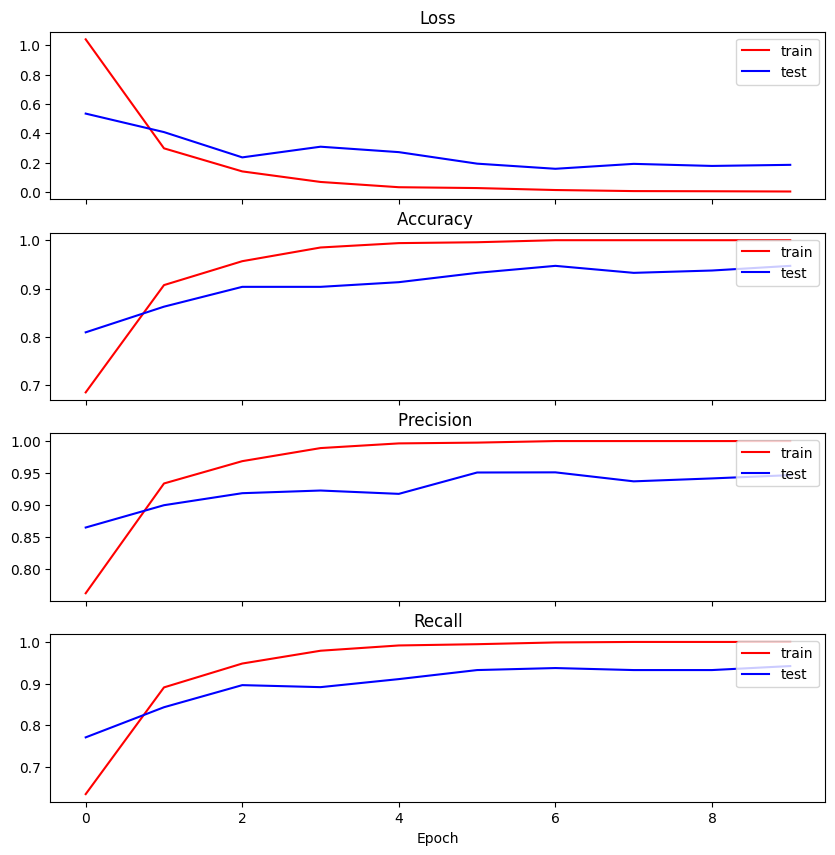

         Model Evaluation on Training :
     Training Loss:     0.03939252346754074
   Training Accuracy:   0.9893975853919983
  Training Precision:   0.9893873333930969
    Training Recall:    0.9884337186813354 

         Model Evaluation on Validation :
    Validation Loss:    1.0426931381225586
  Validation Accuracy:  0.7434715628623962
 Validation Precision:  0.76145339012146
   Validation Recall:   0.7403993606567383


In [23]:
from tensorflow.keras.applications import MobileNetV2

def init_model_with_mobilenetV2():
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(138, 171, 3))
    base_model.trainable = False  # Gel des couches du modèle pré-entraîné

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(13, activation='softmax')  # Adaptez en fonction du nombre de vos classes
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall'])
    
    return model


**Avantages:**

- Haute efficacité et performance: MobileNetV2 affiche des performances impressionnantes avec une précision, une précision et un rappel élevés sur les données d'entraînement, tout en conservant une bonne performance sur les données de validation. Cela indique une capacité de généralisation élevée malgré sa légèreté.
- Rapidité d'entraînement: Le modèle est rapide à entraîner (a duré 2min en tout pour 10 époches).
- Amélioration constante: Les scores de précision, de précision et de rappel s'améliorent régulièrement au fil des époques, montrant une bonne capacité d'apprentissage du modèle.

**Inconvénients:**

- Augmentation de la perte de validation: Bien que la précision de validation reste élevée, il y a une augmentation de la perte de validation dans les dernières époques, ce qui pourrait indiquer un début de surajustement.

=> Meilleur modèle testé.

## Comparaison entre les modèles

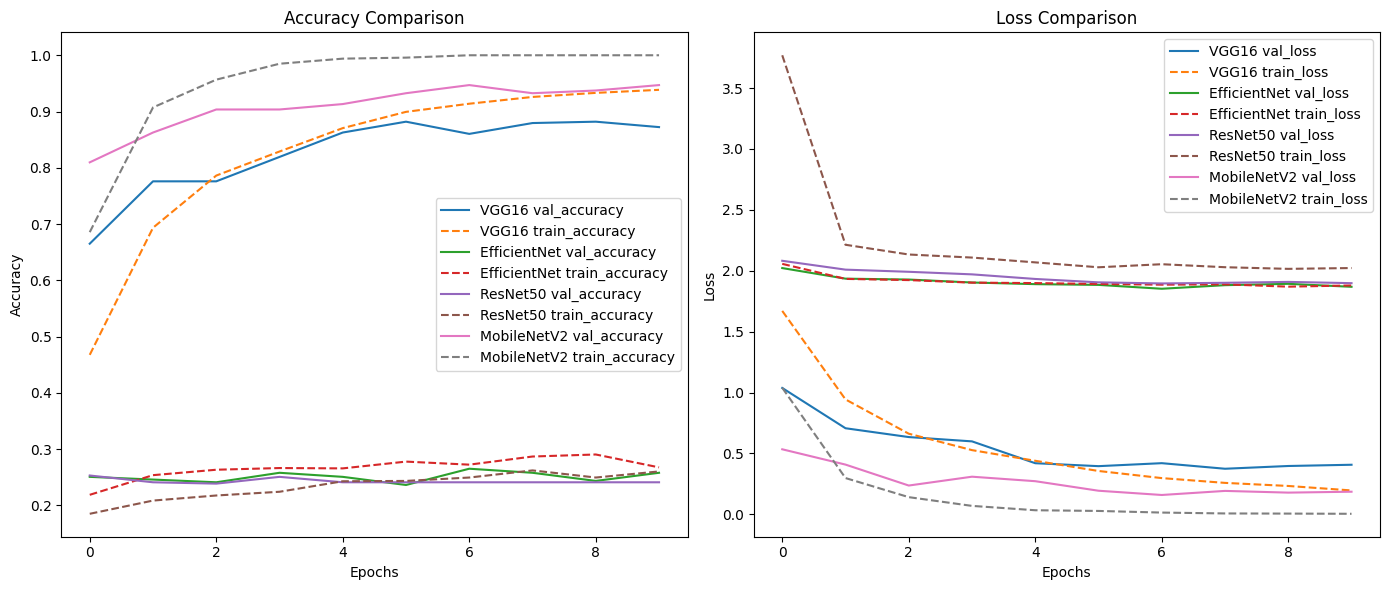

In [24]:
def compare_models(histories, names):
    plt.figure(figsize=(14, 6))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    for name, history in zip(names, histories):
        plt.plot(history.history['val_accuracy'], label=f'{name} val_accuracy')
        plt.plot(history.history['accuracy'], '--', label=f'{name} train_accuracy')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    for name, history in zip(names, histories):
        plt.plot(history.history['val_loss'], label=f'{name} val_loss')
        plt.plot(history.history['loss'], '--', label=f'{name} train_loss')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Supposons que vous ayez l'historique d'EfficientNet et de MobileNetV2, et potentiellement d'autres
compare_models([history_vgg16, history_efficientnet, history_resnet50, history_mobilenetV2], ['VGG16','EfficientNet', 'ResNet50', 'MobileNetV2'])

VGG16 excelle en termes de performance brute, atteignant une haute précision et un rappel, mais au prix de temps d'entraînement plus longs et d'une plus grande consommation de ressources.
ResNet50 et EfficientNet ont montré des performances initiales moins impressionnantes, potentiellement dues à des besoins de réglage fin des hyperparamètres ou à des caractéristiques spécifiques de l'ensemble de données.
MobileNetV2 se distingue par son équilibre entre haute performance et efficacité, offrant une excellente option pour des applications nécessitant à la fois précision et rapidité, tout en étant conscient des ressources. Sa capacité à maintenir une haute précision avec moins de ressources le rend particulièrement attrayant pour des applications à réaliser rapidement.
=> MobileNet V2 est le modèle ayant les meilleurs résultats pour le meilleur temps.